# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    O_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['lock_16_project', 'block_16_project_BN']
    LAST_LAYER = 'block_16_project_BN'
    PREPROCESSING = tf.keras.applications.mobilenet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.dense(o_outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ],
    class_weight=class_weights
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 2.0696 - accuracy: 0.3714

947/947 [==============================] - 2797s 3s/step - loss: 2.0696 - accuracy: 0.3714 - val_loss: 14.5384 - val_accuracy: 0.0067
Epoch 2/200
947/947 [==============================] - 2713s 3s/step - loss: 1.9637 - accuracy: 0.3700 - val_loss: 16.8111 - val_accuracy: 0.0067
Epoch 3/200
947/947 [==============================] - 2715s 3s/step - loss: 1.8301 - accuracy: 0.4151 - val_loss: 19.3790 - val_accuracy: 0.0067
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 1.7175 - accuracy: 0.4664

947/947 [==============================] - 2664s 3s/step - loss: 1.7175 - accuracy: 0.4664 - val_loss: 8.8076 - val_accuracy: 0.0608
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 1.6492 - accuracy: 0.4823

947/947 [==============================] - 2873s 3s/step - loss: 1.6492 - accuracy: 0.4823 - val_loss: 5.6546 - val_accuracy: 0.2749
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 1.6252 - accuracy: 0.5040

947/947 [==============================] - 2867s 3s/step - loss: 1.6252 - accuracy: 0.5040 - val_loss: 3.1857 - val_accuracy: 0.3544
Epoch 7/200
947/947 [==============================] - 2540s 3s/step - loss: 1.6198 - accuracy: 0.4807 - val_loss: 4.3507 - val_accuracy: 0.3124
Epoch 8/200
947/947 [==============================] - 2733s 3s/step - loss: 1.5849 - accuracy: 0.5056 - val_loss: 6.3515 - val_accuracy: 0.2597
Epoch 9/200
947/947 [==============================] - ETA: 0s - loss: 1.5390 - accuracy: 0.5050

947/947 [==============================] - 2710s 3s/step - loss: 1.5390 - accuracy: 0.5050 - val_loss: 1.7212 - val_accuracy: 0.5633
Epoch 10/200
947/947 [==============================] - 2660s 3s/step - loss: 1.4879 - accuracy: 0.5185 - val_loss: 1.9771 - val_accuracy: 0.4589
Epoch 11/200
947/947 [==============================] - 2642s 3s/step - loss: 1.4519 - accuracy: 0.5259 - val_loss: 1.9770 - val_accuracy: 0.6273
Epoch 12/200
947/947 [==============================] - 2720s 3s/step - loss: 1.4509 - accuracy: 0.5213 - val_loss: 5.6922 - val_accuracy: 0.2828
Epoch 13/200
947/947 [==============================] - 2522s 3s/step - loss: 1.4351 - accuracy: 0.5374 - val_loss: 6.4255 - val_accuracy: 0.2992
Epoch 14/200
947/947 [==============================] - 2542s 3s/step - loss: 1.4307 - accuracy: 0.5260 - val_loss: 1.8524 - val_accuracy: 0.5122
Epoch 15/200
947/947 [==============================] - ETA: 0s - loss: 1.3935 - accuracy: 0.5375

947/947 [==============================] - 2745s 3s/step - loss: 1.3935 - accuracy: 0.5375 - val_loss: 1.2135 - val_accuracy: 0.5845
Epoch 16/200
947/947 [==============================] - 2491s 3s/step - loss: 1.3575 - accuracy: 0.5417 - val_loss: 2.2648 - val_accuracy: 0.3656
Epoch 17/200
947/947 [==============================] - ETA: 0s - loss: 1.3342 - accuracy: 0.5393

947/947 [==============================] - 2529s 3s/step - loss: 1.3342 - accuracy: 0.5393 - val_loss: 1.1127 - val_accuracy: 0.5883
Epoch 18/200
947/947 [==============================] - 2438s 3s/step - loss: 1.3219 - accuracy: 0.5605 - val_loss: 1.3395 - val_accuracy: 0.5456
Epoch 19/200
947/947 [==============================] - 2600s 3s/step - loss: 1.2980 - accuracy: 0.5646 - val_loss: 1.4140 - val_accuracy: 0.4994
Epoch 20/200
947/947 [==============================] - 2428s 3s/step - loss: 1.2500 - accuracy: 0.5669 - val_loss: 2.0421 - val_accuracy: 0.4718
Epoch 21/200
947/947 [==============================] - 2426s 3s/step - loss: 1.2779 - accuracy: 0.5708 - val_loss: 1.4998 - val_accuracy: 0.5149
Epoch 22/200
947/947 [==============================] - 2637s 3s/step - loss: 1.2360 - accuracy: 0.5789 - val_loss: 2.0060 - val_accuracy: 0.3988
Epoch 23/200
947/947 [==============================] - 2452s 3s/step - loss: 1.2225 - accuracy: 0.5817 - val_loss: 1.9332 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 256s 2s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9025383317438191,
 'basal cell carcinoma': 0.9086801450555767,
 'dermatofibroma': 0.8728073169066958,
 'melanoma': 0.7492924423790891,
 'nevus': 0.8815586854178145,
 'pigmented benign keratosis': 0.8940526611732057,
 'seborrheic keratosis': 0.8126010225960746,
 'solar lentigo': 0.8992505901190142,
 'squamous cell carcinoma': 0.8730809891524177,
 'vascular lesion': 0.970662768031189}

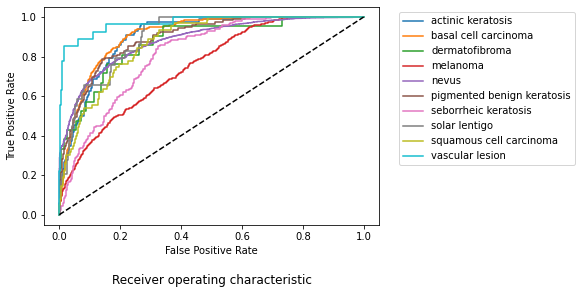

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

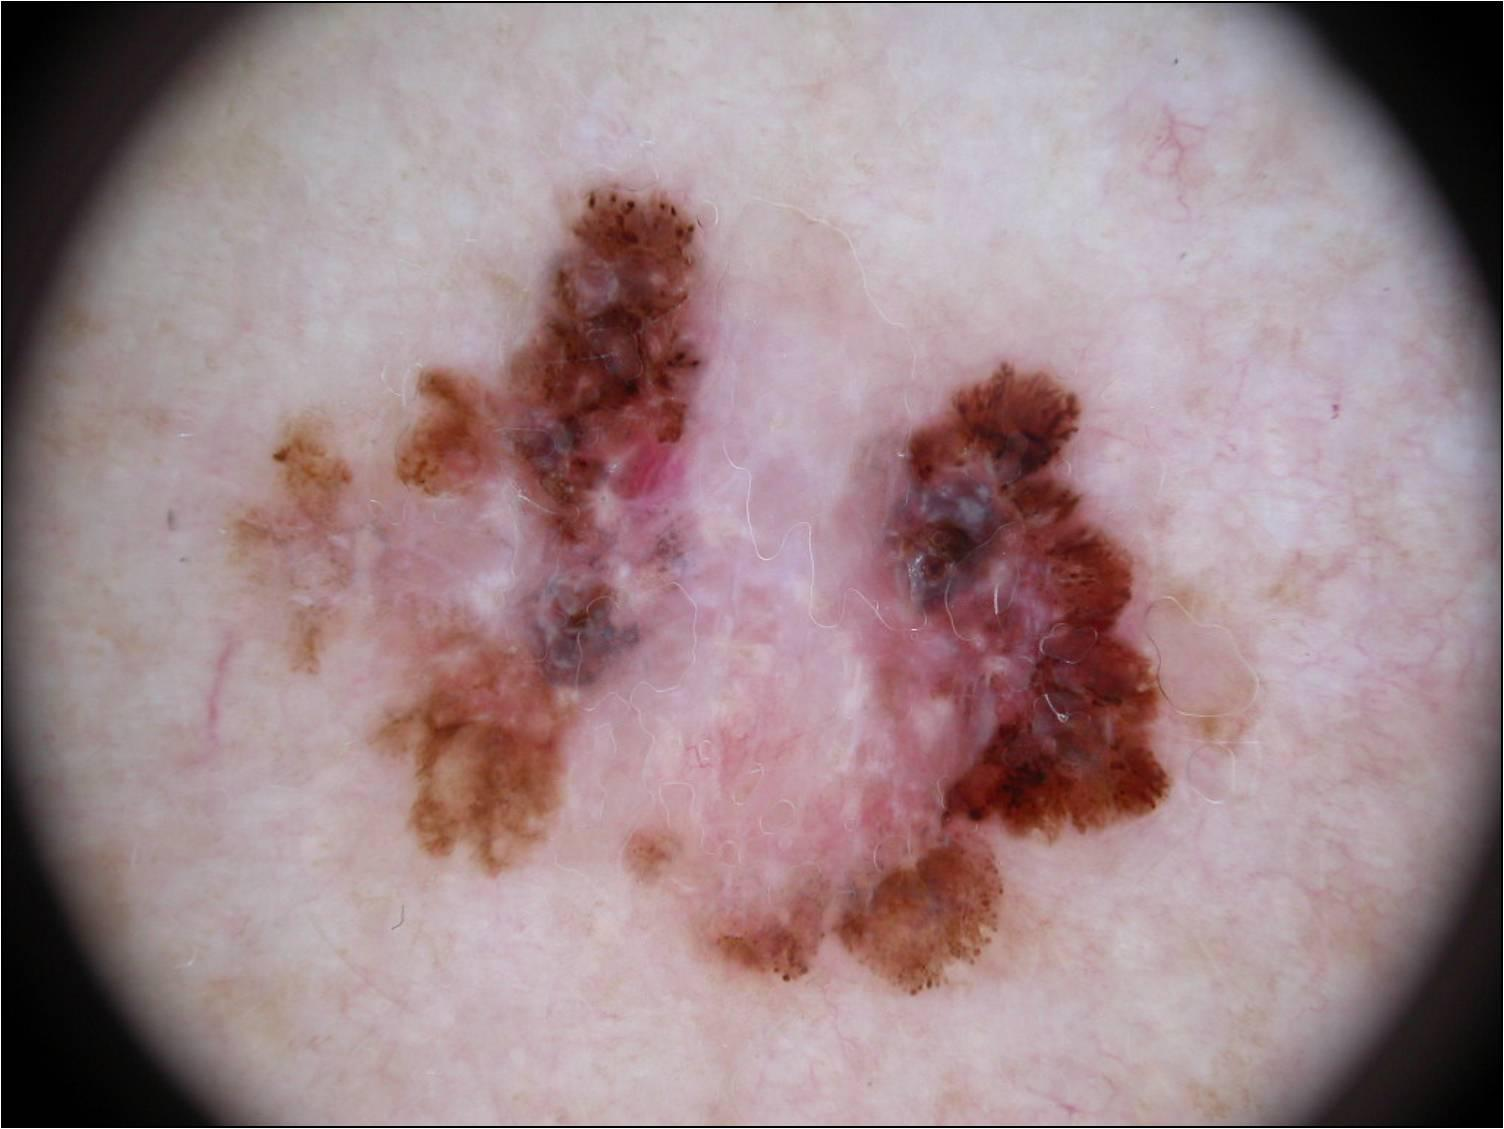

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

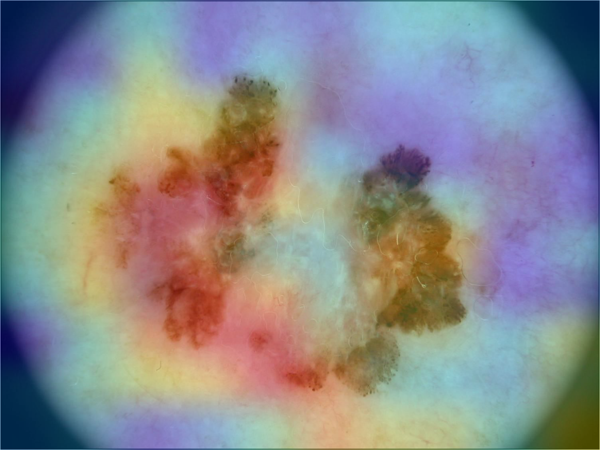

In [23]:
display_gradcam(melanoma_im_path, heatmap)